### Final Code for Sex differences project 

### 1. Prep data set 

In [1]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy.stats import zscore, norm, pearsonr
import matplotlib.pyplot as plt 

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from pathlib import Path

from nltools.stats import fdr

from sklearn.metrics import confusion_matrix


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [134]:
#import data set
df_rest = pd.read_csv("/home/xlajoie/Desktop/Final_restricted.csv")

df_unrest = pd.read_csv("/home/xlajoie/Desktop/Final_unrestricted.csv")


Final_df = pd.merge(df_rest, 
                      df_unrest, 
                      on ='Subject', 
                      how ='inner')
Final_df

,Subject,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,White,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,Black or African Am.,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,101309,29,True,NotTwin,,52385_82248,52385,82248,NaN,Black or African Am.,...,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80
4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,White,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,White,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,White,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,White,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,White,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [15]:
Final_df["Gender"]

0      M
1      M
2      F
3      M
4      M
      ..
669    M
670    M
671    F
672    F
673    F
Name: Gender, Length: 674, dtype: object

In [135]:

# Filter left-handers (include >=50 handedness) 
Final_df = Final_df[Final_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
Final_df.rename(columns={"Subject": "subject_label"}, inplace=True)
Final_df["Gender"] = Final_df["Gender"].replace({"M": 0, "F": 1})
Final_df

,index,subject_label,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,30,True,NotTwin,,56077_85897,56077,85897,NaN,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
566,670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
567,671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
568,672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [136]:
print("hommes = ", Final_df["Gender"].value_counts()[0])
print("femmes = ", Final_df["Gender"].value_counts()[1])

hommes =  264
femmes =  306


In [137]:
from collections import Counter
Counter(Final_df["ZygositySR"])

Counter({'NotTwin': 273, 'NotMZ': 156, 'MZ': 139, ' ': 2})

In [138]:
#save new csv with modifications as "final hcp database"
Final_df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [139]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [21]:
df["Gender"]  # should have the whole list

0      0
1      0
2      1
3      0
4      0
      ..
565    0
566    0
567    1
568    1
569    1
Name: Gender, Length: 570, dtype: int64

In [140]:
#import data set with 2,3,4 resting-state scans 

new_df_rest = pd.read_csv("/home/xlajoie/Desktop/rest_2_3_4_rfmri.csv")

new_df_unrest = pd.read_csv("/home/xlajoie/Desktop/unrest_2_3_4_rfmri.csv")


test2_df = pd.merge(new_df_rest, 
                      new_df_unrest, 
                      on ='Subject', 
                      how ='inner')
test2_df

,Subject,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,24,True,NotTwin,,52259_82122,52259,82122,NaN,White,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,White,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
3,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,Black or African Am.,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
4,101208,35,True,NotMZ,DZ,51330_81195,51330,81195,NaN,Black or African Am.,...,4.4,101.12,87.11,1.0,50.1,105.57,102.32,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,White,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
820,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,White,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
821,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,White,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
822,995174,25,True,MZ,MZ,55923_85743,55923,85743,NaN,White,...,3.6,88.61,64.58,3.0,50.1,117.16,117.40,1.80,0.0,1.80


In [141]:
# Filter left-handers (include >=50 handedness) 
test2_df = test2_df[test2_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
test2_df.rename(columns={"Subject": "subject_label"}, inplace=True)
test2_df["Gender"] = test2_df["Gender"].replace({"M": 0, "F": 1})
test2_df

,index,subject_label,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100004,24,True,NotTwin,,52259_82122,52259,82122,NaN,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,1,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,2,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
3,3,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
4,4,101208,35,True,NotMZ,DZ,51330_81195,51330,81195,NaN,...,4.4,101.12,87.11,1.0,50.1,105.57,102.32,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,819,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
687,820,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
688,821,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
689,822,995174,25,True,MZ,MZ,55923_85743,55923,85743,NaN,...,3.6,88.61,64.58,3.0,50.1,117.16,117.40,1.80,0.0,1.80


In [142]:
#save new csv with modifications as "final hcp database"
test2_df.to_csv("/home/xlajoie/Desktop/HCP_database_TEST2.csv")

In [25]:
from collections import Counter
Counter(test2_df["ZygositySR"])

Counter({'NotTwin': 334, 'NotMZ': 191, 'MZ': 163, ' ': 3})

In [26]:
test2_df.sort_values(by=['Family_ID'], inplace=True)
test2_df

,index,subject_label,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
504,600,571144,25,True,NotTwin,,50371_80310,50371,80310,NaN,...,3.6,108.79,97.19,0.0,38.6,81.89,81.46,1.92,0.0,1.92
519,619,589567,25,True,NotTwin,,50406_80340,50406,80340,NaN,...,5.2,93.38,69.88,0.0,49.7,99.67,100.24,1.92,0.0,1.92
613,730,812746,22,True,NotTwin,,50406_80340,50406,80340,NaN,...,2.8,96.87,77.12,3.0,46.6,83.23,83.12,1.92,0.0,1.92
340,406,213421,26,True,NotTwin,,50532_80448,50532,80448,NaN,...,6.0,108.79,97.19,0.0,48.7,94.30,93.41,1.80,0.0,1.80
352,419,237334,23,True,NotTwin,,50532_80448,50532,80448,NaN,...,3.6,122.25,110.45,0.0,38.6,119.77,120.10,1.80,0.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,693,728454,22,True,NotMZ,DZ,56200_86019,56200,86019,NaN,...,1.2,101.12,87.11,NaN,50.1,84.07,82.37,1.80,1.0,1.76
26,33,108020,22,True,NotMZ,DZ,56200_86019,56200,86019,NaN,...,1.2,108.79,97.19,1.0,38.6,108.46,107.27,1.84,0.0,1.84
533,634,618952,22,True,NotMZ,,56202_86021,56202,86021,NaN,...,3.6,108.79,97.19,0.0,38.6,105.57,103.47,1.80,1.0,1.76
550,652,650746,28,True,NotMZ,,99987_99988,99987,99988,NaN,...,2.8,101.12,86.45,2.0,50.1,80.52,80.00,1.92,3.0,1.80


In [143]:
mz_subject_labels = []
for family_id, data in Final_df.groupby("Family_ID"):
    if len(data) == 2 and (data["ZygositySR"] == "MZ").all():
        #print(family_id)
        mz_subject_labels.append(data["subject_label"].values)
mz_subject_labels

[array([101006, 104820]),
 array([135124, 463040]),
 array([159441, 441939]),
 array([108121, 613538]),
 array([189349, 500222]),
 array([233326, 352738]),
 array([115017, 782561]),
 array([131217, 365343]),
 array([117021, 198047]),
 array([172029, 912447]),
 array([214625, 911849]),
 array([181636, 536647]),
 array([104416, 187345]),
 array([126426, 146735]),
 array([236130, 257542]),
 array([103010, 113316]),
 array([680452, 788674]),
 array([180533, 654552]),
 array([321323, 744553])]

In [144]:
data

,index,subject_label,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
394,464,516742,31,True,NotTwin,,99989_99990,99989,99990,NaN,...,2.8,122.25,111.41,0.0,38.6,75.43,72.72,1.92,0.0,1.92


In [25]:
mz_subject_labels = np.asarray(mz_subject_labels)
test_split = mz_subject_labels
test_split = np.hsplit(test_split, 2)

# filtrage des jumeaux MZ
for i in range(0,len(test_split[1])):
    Final_df = Final_df.drop(Final_df[Final_df.subject_label == test_split[1][i][0]].index)

Final_df

,index,subject_label,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,30,True,NotTwin,,56077_85897,56077,85897,NaN,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
566,670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
567,671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
568,672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


# Atlas Destrieux

#### Bootstrapping

In [213]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(4, -1) # 8
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [3]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [28]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [29]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [145]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}_{seed_name}_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        
        


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [10:52<00:00,  1.14s/it]


In [36]:
def run(df_boot, data, seed):
    df_bootstrap = pd.DataFrame()
    for j in range(0, len(df_boot)):
        index = random.randint(0, len(df_boot)-1)
        frames = [df_bootstrap, df_boot[index:index+1]]
        df_bootstrap = pd.concat(frames)

    df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)


    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_bootstrap)
    subject_label = df_bootstrap["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_bootstrap["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning(x_correl, y_sex)

    return x_correl

100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 19972.88it/s]

0 2


In [133]:
correlation.shape

(2, 1184)

In [37]:
run_1 = run(df, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 450575.44it/s]


train: 456 test: 114
[array([0.76086957, 0.84782609, 0.80434783, 0.84782609, 0.89130435,
       0.86956522, 0.8       , 0.86666667, 0.84444444, 0.75555556])]
predicted class  Femme  Homme
actual class                 
Femme               50      9
Homme                2     53
accuracy test (r2) = 0.9035087719298246
accuracy train (r2) = 1.0


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [38]:
run_1

array([[ 0.48880807, -0.3981449 ,  0.28839993, ..., -0.2419297 ,
         0.59885925,  0.83427674],
       [ 0.5963587 , -0.36532837, -0.2998809 , ...,  0.328905  ,
         0.26458573, -0.08161303],
       [ 0.2212104 , -0.35494286,  0.6410036 , ...,  0.48924026,
        -0.3038715 , -0.54079515],
       ...,
       [ 0.83214307, -0.45723024,  0.39675188, ...,  0.34254774,
        -0.40147755, -0.5512007 ],
       [-0.1204892 , -0.48598975, -0.30662078, ...,  0.80033666,
         0.51115835,  0.54374695],
       [-0.21106765,  0.13483521, -0.02408651, ...,  0.697425  ,
         0.22092938,  0.43372163]], dtype=float32)

# Bootstrap results

In [220]:
import joblib
import numpy as np
from pathlib import Path


study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results" / "models_iteration-10000_seeds-all_pickle.pkl"
results_path_aMTG_L = study_dir / "results" / "models_iteration-10000_seeds-aMTG_L.pkl"
results_path_aMTG_R = study_dir / "results" / "models_iteration-10000_seeds-aMTG_R.pkl"
results_path_opIFG_L = study_dir / "results" / "models_iteration-10000_seeds-opIFG_L.pkl"
results_path_opIFG_R = study_dir / "results" / "models_iteration-10000_seeds-opIFG_R.pkl"
results_path_pITG_L = study_dir / "results" / "models_iteration-10000_seeds-pITG_L.pkl"
results_path_pITG_R = study_dir / "results" / "models_iteration-10000_seeds-pITG_R.pkl"
results_path_planumtemp_L = study_dir / "results" / "models_iteration-10000_seeds-planumtemp_L.pkl"
results_path_planumtemp_R = study_dir / "results" / "models_iteration-10000_seeds-planumtemp_R.pkl"
results_path_all_left = study_dir / "results" / "models_iteration-10000_seeds-left.pkl"
results_path_all_right = study_dir / "results" / "models_iteration-10000_seeds-right.pkl"



results = joblib.load(results_path_all_right)

coefs = []
for result in results:
    coefs.append(result["model"].coef_[0])

coefs = np.array(coefs)
print(coefs.shape)



(10000, 592)


In [221]:
data_results = pd.DataFrame.from_dict(results)

In [222]:
data_results

,len_X_train,len_X_test,score,confusion_matrix,acc_test,acc_train,model
0,451,113,[0.8845410628019325],predicted class Femme Homme actual class ...,0.920354,1.0,LinearSVC(max_iter=10000)
1,451,113,[0.8757487922705314],predicted class Femme Homme actual class ...,0.884956,1.0,LinearSVC(max_iter=10000)
2,451,113,[0.8778743961352659],predicted class Femme Homme actual class ...,0.876106,1.0,LinearSVC(max_iter=10000)
3,451,113,[0.8956521739130435],predicted class Femme Homme actual class ...,0.938053,1.0,LinearSVC(max_iter=10000)
4,451,113,[0.8847342995169083],predicted class Femme Homme actual class ...,0.814159,1.0,LinearSVC(max_iter=10000)
...,...,...,...,...,...,...,...
9995,451,113,[0.8757487922705314],predicted class Femme Homme actual class ...,0.893805,1.0,LinearSVC(max_iter=10000)
9996,451,113,[0.8891304347826086],predicted class Femme Homme actual class ...,0.823009,1.0,LinearSVC(max_iter=10000)
9997,451,113,[0.8845893719806763],predicted class Femme Homme actual class ...,0.867257,1.0,LinearSVC(max_iter=10000)
9998,451,113,[0.8847342995169081],predicted class Femme Homme actual class ...,0.805310,1.0,LinearSVC(max_iter=10000)


In [223]:
moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)

In [224]:
moyenne.shape

(592,)

In [225]:
coefs

array([[-0.25487679, -0.15287455, -0.0285894 , ...,  0.01887876,
        -0.0521843 ,  0.04065553],
       [-0.18667589, -0.14688001, -0.08414651, ...,  0.11968607,
        -0.07950314,  0.20914108],
       [-0.12598542, -0.14616489, -0.12756619, ...,  0.05044749,
        -0.0501931 , -0.00982729],
       ...,
       [-0.11467926, -0.04923274, -0.14647224, ...,  0.22152965,
        -0.04214047,  0.02614698],
       [-0.05762677, -0.15995586, -0.04837858, ...,  0.16423525,
        -0.12934392, -0.08552712],
       [-0.20877789, -0.31326163, -0.15874611, ...,  0.12813004,
        -0.0532923 , -0.15246013]])

In [226]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]


def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
    
    
    # plotting the ROIs
    atlas_dest = datasets.fetch_atlas_destrieux_2009()
    masker = NiftiLabelsMasker(atlas_dest.maps)
    masker.fit()
    coef_image = vector2img4d(weighted_coef, masker)
    
    # plot and saving
    i = 0
    for img in image.iter_img(coef_image):
        # img is now an in-memory 3D img
        display = plotting.plot_glass_brain(img,display_mode = "lyrz", colorbar=True)
        display.savefig("discriminant regions_"+str(i)+".png", dpi=300)
        i = i + 1
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

     coefficient          seed                    labels
367     0.167958        aMTG_R          L S_temporal_inf
6       0.164970       opIFG_R  L G_and_S_cingul-Mid-Ant
308     0.162805        aMTG_R     L G_front_inf-Orbital
302     0.131554        aMTG_R  L G_and_S_cingul-Mid-Ant
420     0.129734        aMTG_R    R S_collat_transv_post
331     0.124794        aMTG_R   L G_temp_sup-Plan_tempo
274     0.123444  planumtemp_R          R S_front_middle
385     0.122892        aMTG_R             R G_front_sup
314     0.121971        aMTG_R      L G_occipital_middle
410     0.121686        aMTG_R            R Lat_Fis-post


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


The mean accuracy : 0.8846327433628319
The standard deviation of the accuracy : 0.03203755890381336
The lower boundry of the confidance interval of the accuracy : 0.8218391279113577
The upper boundry of the confidance interval of the accuracy : 0.9474263588143061


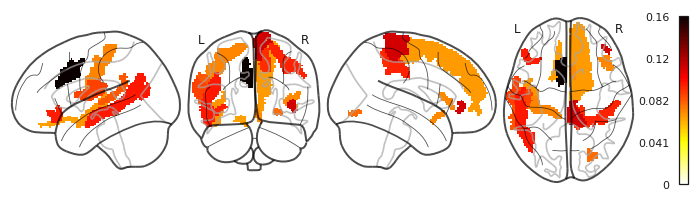

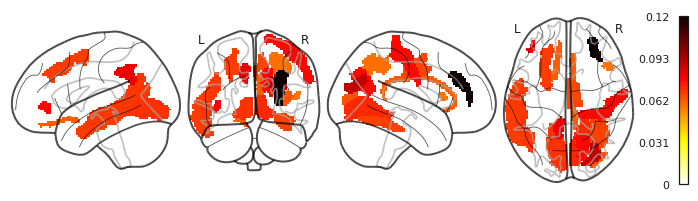

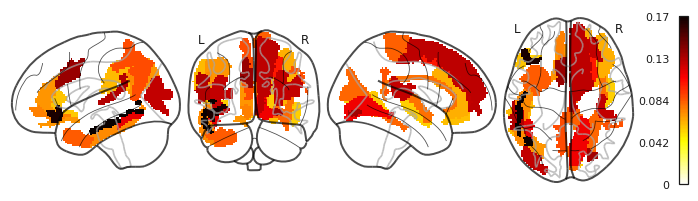

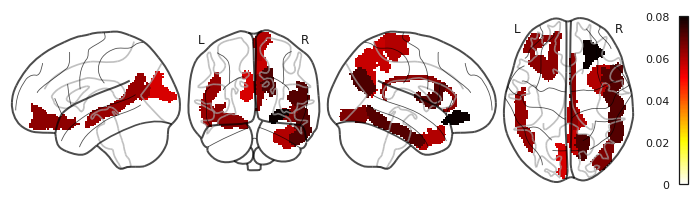

In [227]:
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)

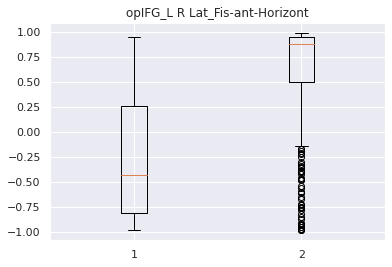

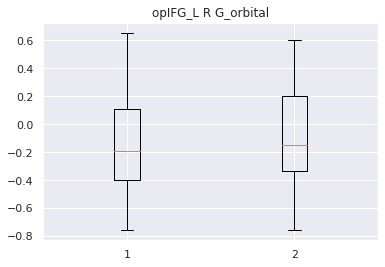

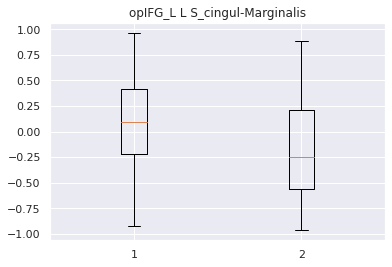

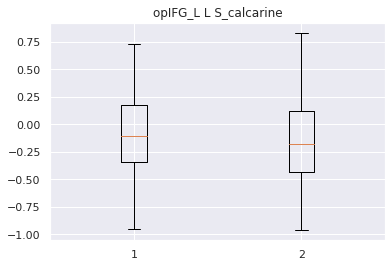

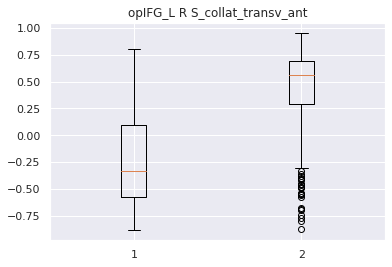

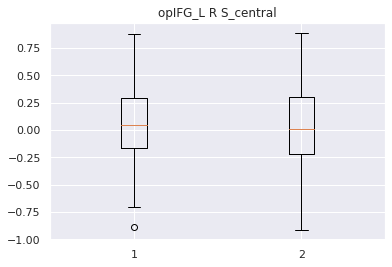

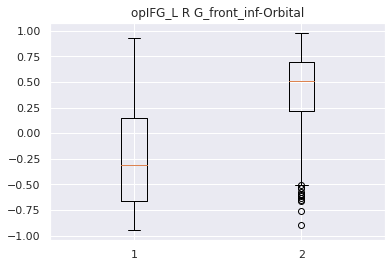

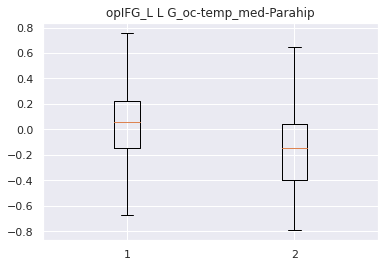

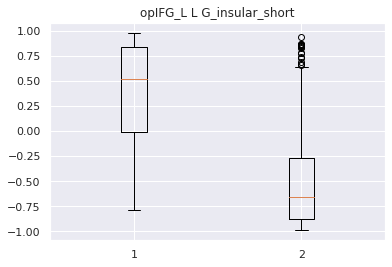

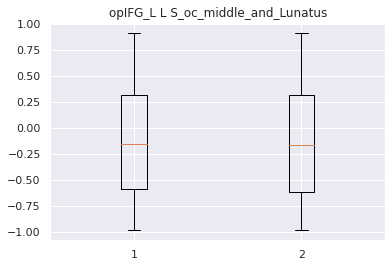

In [148]:
best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
best_roi = []

for row in best.iterrows():
    best_roi.append([row[1][1], row[1][2], [], []])
    
label_female = []
label_male = []

for i in range(0,len(Final_df["Gender"])):
    if Final_df["Gender"][i] == 0:
        label_male.append(Final_df["subject_label"][i])
        
    elif Final_df["Gender"][i] == 1:
        label_female.append(Final_df["subject_label"][i])
        

for i in data.keys():
    if label_male.count(i[0]) > 0:
        for j in range(0, len(best_roi)):
            if (best_roi[j][0] == i[1]):
                best_roi[j][2].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])
    
    elif label_female.count(i[0]) > 0:
        for j in range(0, len(best_roi)):
            if (best_roi[j][0] == i[1]):
                best_roi[j][3].append(data[i[0], best_region[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])
        
for i in range(0, len(best_roi)):
    best_roi[i][2] = np.asarray(best_roi[i][2])
    best_roi[i][3] = np.asarray(best_roi[i][3])
    plt.boxplot([best_roi[i][2], best_roi[i][3]])
    plt.title(best_roi[i][0]+" "+best_roi[i][1])
    plt.show()

In [123]:
best_roi

[['opIFG_L', 'R Lat_Fis-ant-Horizont', [], []],
 ['opIFG_L', 'R G_orbital', [], []],
 ['opIFG_L', 'L S_cingul-Marginalis', [], []],
 ['opIFG_L', 'L S_calcarine', [], []],
 ['opIFG_L', 'R S_collat_transv_ant', [], []],
 ['opIFG_L', 'R S_central', [], []],
 ['opIFG_L', 'R G_front_inf-Orbital', [], []],
 ['opIFG_L', 'L G_oc-temp_med-Parahip', [], []],
 ['opIFG_L', 'L G_insular_short', [], []],
 ['opIFG_L', 'L S_oc_middle_and_Lunatus', [], []]]

In [62]:
data_fdr = pd.DataFrame(fdr_val, columns=["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])
data_fdr

,opIFG_L,planumtemp_L,aMTG_L,pITG_L,opIFG_R,planumtemp_R,aMTG_R,pITG_R
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
pvalue.shape

(1184,)

In [60]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)

In [61]:
label = atlas_dest["labels"].drop([0,42,117])
label = label.reset_index()
label

,index,name
0,1,L G_and_S_frontomargin
1,2,L G_and_S_occipital_inf
2,3,L G_and_S_paracentral
3,4,L G_and_S_subcentral
4,5,L G_and_S_transv_frontopol
...,...,...
143,146,R S_suborbital
144,147,R S_subparietal
145,148,R S_temporal_inf
146,149,R S_temporal_sup


In [213]:
# pvalue_val = np.mean(pvalue, axis=0)
pvalue_val = pvalue.reshape(8, 148).T
pvalue_uncorrected = pvalue_val < 0.05


data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])
data_pval_uncorrected

data_pval = pd.DataFrame(pvalue_val, columns=["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)

In [113]:
data_pval

,opIFG_L,planumtemp_L,aMTG_L,pITG_L,opIFG_R,planumtemp_R,aMTG_R,pITG_R
0,0.779201,0.932782,0.419688,0.792936,0.186317,0.158302,0.505349,0.715976
1,0.238451,0.478393,0.708973,0.655993,0.990225,0.549490,0.496403,0.853759
2,0.191651,0.269302,0.350086,0.792870,0.590525,0.231344,0.258157,0.022535
3,0.934838,0.910593,0.469692,0.481382,0.489829,0.972163,0.904710,0.840392
4,0.727122,0.753986,0.641585,0.908725,0.695869,0.126361,0.742191,0.545051
...,...,...,...,...,...,...,...,...
143,0.719802,0.515389,0.309675,0.768083,0.133122,0.927406,0.641491,0.795403
144,0.239799,0.447961,0.826180,0.909583,0.439904,0.890371,0.718947,0.417519
145,0.075383,0.485385,0.700391,0.154675,0.344509,0.942958,0.537204,0.878798
146,0.151313,0.312027,0.253448,0.055952,0.607673,0.126026,0.124423,0.246335


In [125]:
data_pval["labels"] = label["name"]
data_pval

,opIFG_L,planumtemp_L,aMTG_L,pITG_L,opIFG_R,planumtemp_R,aMTG_R,pITG_R,labels
0,0.779201,0.932782,0.419688,0.792936,0.186317,0.158302,0.505349,0.715976,L G_and_S_frontomargin
1,0.238451,0.478393,0.708973,0.655993,0.990225,0.549490,0.496403,0.853759,L G_and_S_occipital_inf
2,0.191651,0.269302,0.350086,0.792870,0.590525,0.231344,0.258157,0.022535,L G_and_S_paracentral
3,0.934838,0.910593,0.469692,0.481382,0.489829,0.972163,0.904710,0.840392,L G_and_S_subcentral
4,0.727122,0.753986,0.641585,0.908725,0.695869,0.126361,0.742191,0.545051,L G_and_S_transv_frontopol
...,...,...,...,...,...,...,...,...,...
143,0.719802,0.515389,0.309675,0.768083,0.133122,0.927406,0.641491,0.795403,R S_suborbital
144,0.239799,0.447961,0.826180,0.909583,0.439904,0.890371,0.718947,0.417519,R S_subparietal
145,0.075383,0.485385,0.700391,0.154675,0.344509,0.942958,0.537204,0.878798,R S_temporal_inf
146,0.151313,0.312027,0.253448,0.055952,0.607673,0.126026,0.124423,0.246335,R S_temporal_sup


In [135]:
# not necessary
for index, row in data_pval.iterrows():
    if (row['opIFG_L'] < 0.05 or row['opIFG_R'] < 0.05
        or row['planumtemp_L'] < 0.05 or row['planumtemp_R'] < 0.05
        or row['aMTG_L'] < 0.05 or row['aMTG_R'] < 0.05
        or row['pITG_L'] < 0.05 or row['pITG_R'] < 0.05):
        print(row['labels'])

L G_and_S_paracentral
L G_and_S_cingul-Mid-Post
L G_cingul-Post-dorsal
L G_cuneus
L G_front_inf-Opercular
L G_front_inf-Orbital
L G_front_sup
L G_oc-temp_lat-fusifor
L G_oc-temp_med-Lingual
L G_orbital
L G_parietal_sup
L G_postcentral
L G_precentral
L G_precuneus
L Lat_Fis-post
L S_calcarine
L S_collat_transv_ant
L S_front_sup
L S_oc_middle_and_Lunatus
L S_oc_sup_and_transversal
L S_oc-temp_lat
L S_orbital_med-olfact
L S_suborbital
L S_temporal_inf
R G_and_S_frontomargin
R G_and_S_subcentral
R G_and_S_transv_frontopol
R G_and_S_cingul-Mid-Ant
R G_cingul-Post-dorsal
R G_front_inf-Opercular
R G_front_inf-Triangul
R G_Ins_lg_and_S_cent_ins
R G_insular_short
R G_occipital_sup
R G_oc-temp_med-Lingual
R G_pariet_inf-Supramar
R G_precuneus
R G_rectus
R G_temp_sup-G_T_transv
R G_temp_sup-Lateral
R G_temp_sup-Plan_polar
R G_temporal_middle
R Lat_Fis-ant-Horizont
R Lat_Fis-ant-Vertical
R Lat_Fis-post
R Pole_occipital
R Pole_temporal
R S_calcarine
R S_central
R S_cingul-Marginalis
R S_circular_in

In [240]:
X_std = x_correl.std()
weighted_coef = moyenne * X_std
label_name = list(label['name']) * 8
seed_name = np.repeat(["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"], 148)

X_std = x_correl.std()
weighted_coef = moyenne * X_std
label_name = list(label['name']) * ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
seed_name = np.repeat(["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"], 148)

In [243]:
weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
weighted_tab['seed'] = seed_name
weighted_tab['labels'] = label_name

,coefficient,seed,labels
0,-0.006248,opIFG_L,L G_and_S_frontomargin
1,0.001833,opIFG_L,L G_and_S_occipital_inf
2,0.016998,opIFG_L,L G_and_S_paracentral
3,-0.005667,opIFG_L,L G_and_S_subcentral
4,0.031565,opIFG_L,L G_and_S_transv_frontopol
...,...,...,...
145,0.025557,opIFG_L,R S_temporal_inf
146,-0.020252,opIFG_L,R S_temporal_sup
147,0.007898,opIFG_L,R S_temporal_transverse
148,0.002958,planumtemp_L,L G_and_S_frontomargin


In [246]:
weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10)

,coefficient,seed,labels
959,0.075502,aMTG_R,L S_temporal_inf
453,0.074514,pITG_L,L G_cingul-Post-ventral
866,0.068460,planumtemp_R,R S_front_middle
598,0.067376,opIFG_R,L G_and_S_cingul-Mid-Ant
1014,0.067225,aMTG_R,R S_front_middle
900,0.059836,aMTG_R,L G_front_inf-Orbital
1012,0.059585,aMTG_R,R S_collat_transv_post
1002,0.057025,aMTG_R,R Lat_Fis-post
923,0.054872,aMTG_R,L G_temp_sup-Plan_tempo
983,0.054609,aMTG_R,R G_oc-temp_med-Lingual


In [214]:
pd.DataFrame(weighted_coef.reshape(8, 148).T, columns=["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

,opIFG_L,planumtemp_L,aMTG_L,pITG_L,opIFG_R,planumtemp_R,aMTG_R,pITG_R
0,-0.006248,0.002958,0.028016,0.017594,-0.045890,-0.008287,-0.024670,-0.015398
1,0.001833,-0.003099,-0.014334,0.004161,-0.040620,-0.034315,0.014874,-0.063012
2,0.016998,-0.002059,-0.000999,0.020623,-0.027174,-0.013419,-0.017257,-0.006708
3,-0.005667,-0.021009,0.026461,-0.008975,0.046112,-0.027344,-0.000738,0.005790
4,0.031565,-0.015979,-0.006765,0.011666,-0.005493,-0.048709,-0.029444,-0.028258
...,...,...,...,...,...,...,...,...
143,0.019511,-0.007597,0.032997,0.015686,-0.043874,-0.038528,-0.046647,-0.030557
144,0.009221,-0.002316,-0.014470,0.040900,0.019282,-0.033736,-0.033772,-0.007554
145,0.025557,-0.003409,0.018131,-0.019463,-0.022136,-0.024373,-0.022521,0.003777
146,-0.020252,-0.006145,-0.018934,-0.008996,-0.016700,0.004499,0.015097,-0.013455


In [209]:
weigthed_coef[:148]

array([-0.00624825,  0.00183281,  0.01699779, -0.005667  ,  0.03156481,
       -0.02411401, -0.01255995,  0.00731219,  0.02431351, -0.01778727,
       -0.00625503,  0.00714223, -0.00024191,  0.01232415, -0.01266103,
        0.00294256,  0.02687756,  0.01752396, -0.01728286, -0.00487604,
       -0.00931922, -0.02214227,  0.02465957, -0.03602658, -0.0016903 ,
       -0.00196556,  0.01527389,  0.0137145 , -0.01174282,  0.00056468,
       -0.00256825,  0.00490876,  0.00708097,  0.00595663,  0.00920917,
        0.00189407, -0.00636861, -0.0285514 , -0.00481643,  0.01267059,
        0.00548665, -0.00719319,  0.00250156,  0.01208936,  0.02503322,
        0.03915191, -0.02031446,  0.0225291 , -0.00312234,  0.02775036,
       -0.01917088,  0.02360431,  0.01822303, -0.01501896, -0.00124888,
        0.01429466,  0.01805573, -0.00885703, -0.01112193, -0.04378919,
       -0.00155062, -0.00462267, -0.03398967,  0.0305824 , -0.0048739 ,
       -0.00130223,  0.04910734,  0.03051146,  0.01104438,  0.00

In [107]:
np.multiply((pvalue_val <= 0.05), pvalue_val).any()

True

In [249]:
weighted_coef[weighted_coef<0.054609] = 0
weighted_coef

array([0., 0., 0., ..., 0., 0., 0.])

In [250]:
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)
masker.fit()
coef_image = vector2img4d(weighted_coef, masker)

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:373: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


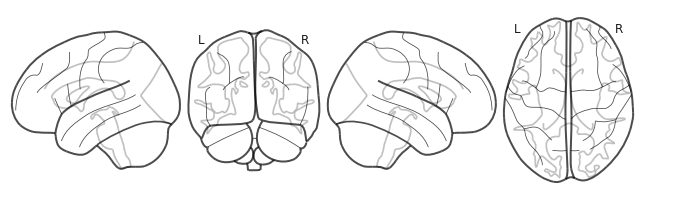

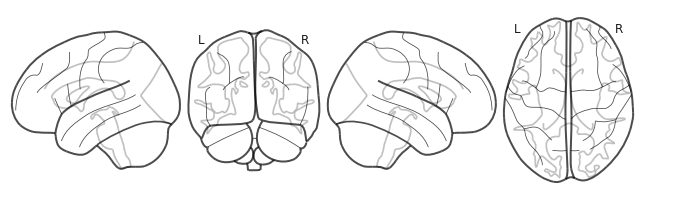

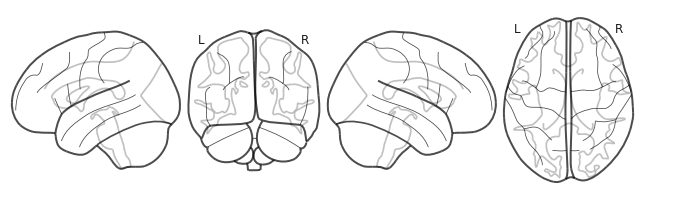

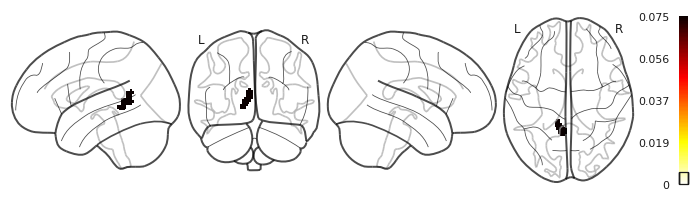

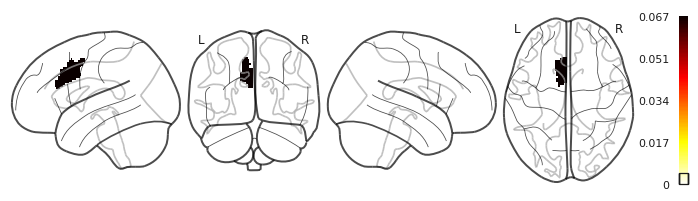

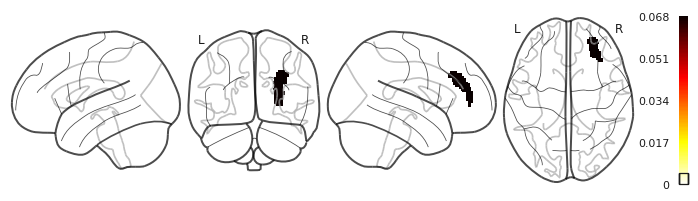

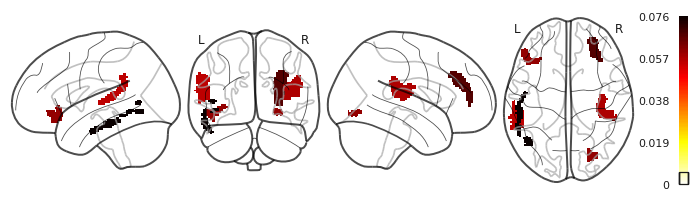

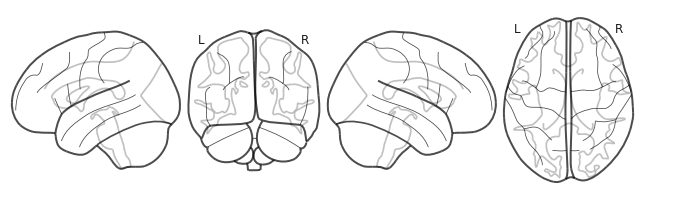

In [251]:
i = 0
for img in image.iter_img(coef_image):
    # img is now an in-memory 3D img
    display = plotting.plot_glass_brain(img,display_mode = "lyrz", colorbar=True)
    display.savefig("discriminant regions_"+str(i)+".png", dpi=300)
    i = i + 1

In [153]:
acc_test = np.asarray(data["acc_test"])
moy = np.mean(acc_test)
se = np.std(acc_test)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print(moy)
print(se)
print(lower)
print(upper)

0.8756353982300885
0.032657349067499834
0.8116269940577888
0.9396438024023882


# Classification seed par seed, 4 a gauche, 4 a droite

In [28]:
y_sex = df_bootstrap["Gender"][:nb_subjects]   # maybe list(df["Gender"]) 
seeds = np.array([seed_1, seed_2, seed_3, seed_4, seed_5, seed_6, seed_7, seed_8])


for i in range(0, len(seeds)):
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        seeds[i],  # x 
                                                        y_sex,       # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score = cross_val_score(model, X_train, y_train, cv=10)
    #score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('seed_'+str(i+1)+' accuracy test (r2) =', acc_test)
    
    

train: 160 test: 40


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.9375 0.8125 0.75   0.8125 0.9375 0.875  0.625  0.875  0.75   0.5625]
predicted class  Femme  Homme
actual class                 
Femme               21      2
Homme                0     17
seed_1 accuracy test (r2) = 0.95
train: 160 test: 40


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.75   0.8125 0.75   0.6875 0.5625 0.75   0.75   0.875  0.6875 0.6875]
predicted class  Femme  Homme
actual class                 
Femme               20      3
Homme                4     13
seed_2 accuracy test (r2) = 0.825
train: 160 test: 40


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.75   0.875  0.9375 0.8125 0.9375 0.875  0.6875 0.75   0.75   0.8125]
predicted class  Femme  Homme
actual class                 
Femme               20      3
Homme                1     16
seed_3 accuracy test (r2) = 0.9
train: 160 test: 40
[0.9375 0.8125 0.6875 0.875  0.5625 0.75   0.75   0.8125 0.8125 0.5   ]
predicted class  Femme  Homme
actual class                 
Femme               23      0
Homme                2     15
seed_4 accuracy test (r2) = 0.95
train: 160 test: 40


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.875  0.8125 0.625  0.6875 0.75   0.875  0.75   0.8125 0.8125 0.5625]
predicted class  Femme  Homme
actual class                 
Femme               18      5
Homme                2     15
seed_5 accuracy test (r2) = 0.825
train: 160 test: 40
[0.9375 0.9375 0.75   0.6875 0.8125 0.75   0.625  0.75   0.5625 0.6875]
predicted class  Femme  Homme
actual class                 
Femme               19      4
Homme                4     13
seed_6 accuracy test (r2) = 0.8
train: 160 test: 40


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.9375 0.8125 0.9375 0.875  0.875  0.9375 0.8125 0.9375 0.625  0.6875]
predicted class  Femme  Homme
actual class                 
Femme               23      0
Homme                2     15
seed_7 accuracy test (r2) = 0.95
train: 160 test: 40
[0.9375 0.875  0.8125 0.75   0.875  0.875  0.8125 0.75   0.625  0.5625]
predicted class  Femme  Homme
actual class                 
Femme               20      3
Homme                6     11
seed_8 accuracy test (r2) = 0.775


In [29]:
seed_left = np.concatenate((seed_1, seed_2, seed_3, seed_4), axis=1)
seed_right = np.concatenate((seed_5, seed_6, seed_7, seed_8), axis=1)

seed_l_r = np.asarray([seed_left, seed_right])

for i in range(0, len(seed_l_r)):
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        seed_l_r[i],  # x 
                                                        y_sex,       # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score = cross_val_score(model, X_train, y_train, cv=10)
    #score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('seed (0: left, 1: right) '+str(i)+' accuracy test (r2) =', acc_test)
    print('seed (0: left, 1:right) '+str(i)+' accuracy train (r2) =', acc_train,"\n")


train: 160 test: 40


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of

[0.875  0.875  0.875  0.8125 0.875  0.8125 0.625  1.     0.75   0.5   ]
predicted class  Femme  Homme
actual class                 
Femme               22      1
Homme                2     15
seed (0: left, 1: right) 0 accuracy test (r2) = 0.925
seed (0: left, 1:right) 0 accuracy train (r2) = 1.0 

train: 160 test: 40


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of

[0.9375 0.75   0.875  0.75   0.9375 0.9375 0.8125 0.8125 0.75   0.6875]
predicted class  Femme  Homme
actual class                 
Femme               20      3
Homme                1     16
seed (0: left, 1: right) 1 accuracy test (r2) = 0.9
seed (0: left, 1:right) 1 accuracy train (r2) = 1.0 



/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of

# Seed to top ten ROIs

In [131]:
label_female = []
label_male = []

for i in range(0,len(Final_df["Gender"])):
    if Final_df["Gender"][i] == 0:
        label_male.append(Final_df["subject_label"][i])
        
    elif Final_df["Gender"][i] == 1:
        label_female.append(Final_df["subject_label"][i])

        
best_region = [["aMTG_R", "L S_temporal_inf", [], []], 
               ["pITG_L", "L G_cingul-Post-ventral", [], []], 
               ["planumtemp_R", "R S_front_middle", [], []], 
               ["opIFG_R", "L G_and_S_cingul-Mid-Ant", [], []], 
               ["aMTG_R", "R S_front_middle", [], []], 
               ["aMTG_R", "L G_front_inf-Orbital", [], []], 
               ["aMTG_R", "R S_collat_transv_post", [], []], 
               ["aMTG_R", "R Lat_Fis-post", [], []], 
               ["aMTG_R", "L G_temp_sup-Plan_tempo", [], []], 
               ["aMTG_R", "R G_oc-temp_med-Lingual", [], []]]



In [132]:
for j in range(0, len(best_region)):
    print(best_region[j][0])

aMTG_R
pITG_L
planumtemp_R
opIFG_R
aMTG_R
aMTG_R
aMTG_R
aMTG_R
aMTG_R
aMTG_R


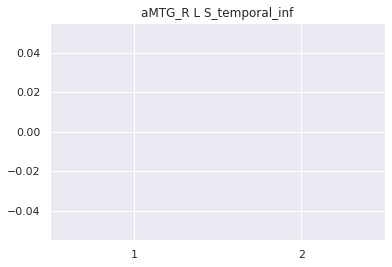

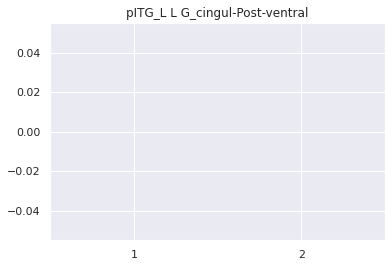

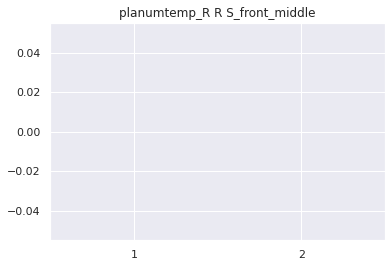

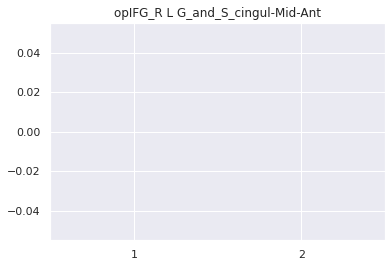

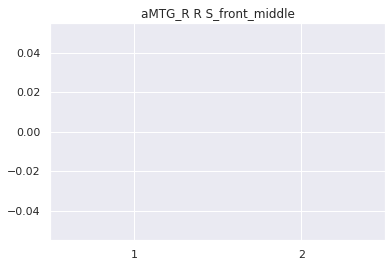

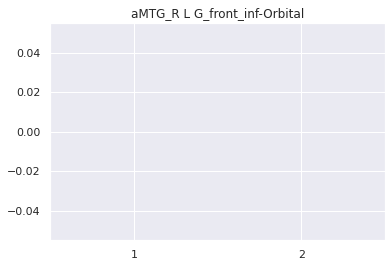

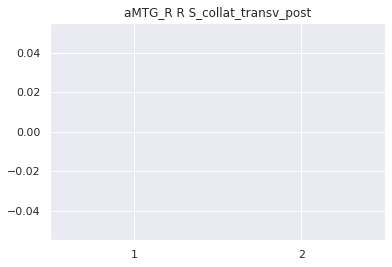

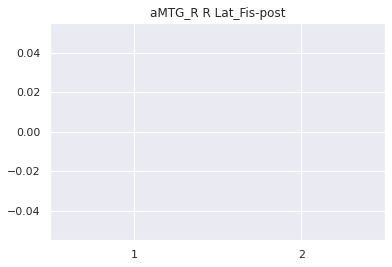

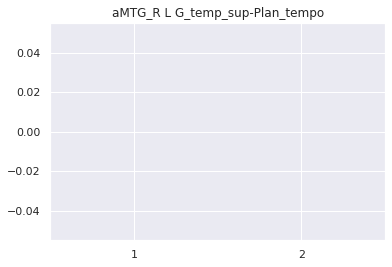

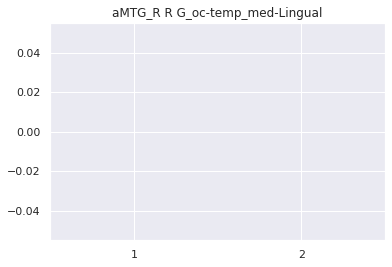

In [133]:
for i in data.keys():
    if label_male.count(i[0]) > 0:
        for j in range(0, len(best_region)):
            if (best_region[j][0] == i[1]):
                best_region[j][2].append(data[i[0], best_region[j][0]][label[label["name"] == best_region[j][1]].index.values[0]])
    
    elif label_female.count(i[0]) > 0:
        for j in range(0, len(best_region)):
            if (best_region[j][0] == i[1]):
                best_region[j][3].append(data[i[0], best_region[j][0]][label[label["name"] == best_region[j][1]].index.values[0]])
        
for i in range(0, len(best_region)):
    best_region[i][2] = np.asarray(best_region[i][2])
    best_region[i][3] = np.asarray(best_region[i][3])
    plt.boxplot([best_region[i][2], best_region[i][3]])
    plt.title(best_region[i][0]+" "+best_region[i][1])
    plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3aac2aba60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3aac2abf40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3aac2ab790>,
 'medians': [<matplotlib.lines.Line2D at 0x7f3aac2bb460>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3aac2bb730>,
 'means': []}

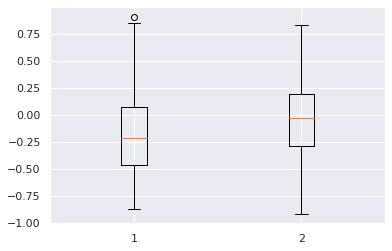

In [207]:

plt.boxplot([best_region[0][2], best_region[0][3]])